# Predictive Maintenance - Classification Approach

> Task 1 - build a model to answer a question
question: Model the err, and errf columns for individual 'scanners' to show a expected failure rate of the encoder component. Scanners identified into two groups, based on the following criteria and grouping:

  never fail: scanners whom never reach the 12 % range for err
  routinely fail: scanners whom reach the 12% range for err on a routine basis

  err and errf are both float values, they are loosely tied to each other, and are not a 1 for 1 relationship, e.g. a rising err value doesn't mean a errf value will rise, nor the opposite. Failure is defined as a err that is above 12 % and/or a errf that is above 0.5 %


  background: err and errf represent a encoder error rate at which a led light is pulsating into a window barrier. This barrier, and subsequent calculation, represent the rate of rotation of a component, and the compensated ERRor and ERRor Filtered value.

>task 2 - explain why the model was chosen to answer the question asked

>task 3 - explain the performance of the model, and of other models that would prove the same question.

>task-5: Build documentation and share it across.

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('seaborn-whitegrid')
from plotly import __version__


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import re

<ipython-input-104-68f83b440201>:9: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [ ]:
df = pd.read_csv("/content/encoders (1).csv", parse_dates=['date'], infer_datetime_format=True)

<ipython-input-105-0e122ee45a4a>:1: FutureWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



In [ ]:
df.head(500)

,id,date,scanner,min,max,err,pixels,minf,maxf,errf,created_at,updated_at
0,12,2017-12-17,K219,35435,35933,1.40,6,35681,35688,0.02,NaN,2017-12-29 16:26:16.475205
1,30,2017-12-18,H161,35155,36382,3.43,14,35731,35761,0.08,NaN,2017-12-29 16:26:16.872783
2,47,2017-12-18,K211,35305,36042,2.07,43,35692,35739,0.13,NaN,2017-12-19 18:10:57.453846
3,48,2017-12-18,K212,35216,36225,2.82,61,35686,35726,0.11,NaN,2017-12-19 18:10:57.45983
4,49,2017-12-18,K220,35196,36259,2.98,11,35709,35724,0.04,NaN,2017-12-19 18:10:57.464388
...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,2017-12-29,K250,35232,36040,2.27,17,35696,35709,0.04,NaN,NaN
496,497,2017-12-30,K237,35459,36026,1.59,12,35711,35719,0.02,NaN,NaN
497,498,2017-12-30,K238,35115,36354,3.47,7,35709,35716,0.02,NaN,NaN
498,499,2017-12-30,K239,35169,36391,3.42,21,35721,35728,0.02,NaN,NaN


Note:
> From the "updates_at" value we can get the duration of which scanner worked before doing the measurement

In [ ]:
df['updated_at'] = np.where(df['updated_at']=='?', df['date'].dt.strftime('%Y-%m-%d %H:%M:%S.%f'), df['updated_at'])

In [ ]:
df['updated_at'] = df['updated_at'].astype(str).apply(lambda x: x.replace("'", "") if pd.notnull(x) else x)

In [ ]:
df['updated_at']  = pd.to_datetime(df['updated_at'])

In [ ]:
type(df['updated_at'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
df['duration'] = df['updated_at']-df['date']
df['duration'] = df['duration'].apply(lambda x:x.days)

In [ ]:
df = df.drop(['updated_at','date'],axis= 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          2752 non-null   int64  
 1   scanner     2752 non-null   object 
 2   min         2752 non-null   int64  
 3   max         2752 non-null   int64  
 4   err         2752 non-null   float64
 5   pixels      2752 non-null   int64  
 6   minf        2752 non-null   int64  
 7   maxf        2752 non-null   int64  
 8   errf        2752 non-null   float64
 9   created_at  0 non-null      float64
 10  duration    1921 non-null   float64
dtypes: float64(4), int64(6), object(1)
memory usage: 236.6+ KB


Data Clean-up: Removing rows which is not having any recorded value


In [ ]:
 df = df.loc[~((df['min']<=0) & (df['max']<=0) & (df['err'] <= 0)),:]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2603 entries, 0 to 2751
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          2603 non-null   int64  
 1   scanner     2603 non-null   object 
 2   min         2603 non-null   int64  
 3   max         2603 non-null   int64  
 4   err         2603 non-null   float64
 5   pixels      2603 non-null   int64  
 6   minf        2603 non-null   int64  
 7   maxf        2603 non-null   int64  
 8   errf        2603 non-null   float64
 9   created_at  0 non-null      float64
 10  duration    1810 non-null   float64
dtypes: float64(4), int64(6), object(1)
memory usage: 244.0+ KB


"created_at" column contains 0 non null value so we must delete this column from the dataframe

In [ ]:
df.columns

Index(['id', 'scanner', 'min', 'max', 'err', 'pixels', 'minf', 'maxf', 'errf',
       'created_at', 'duration'],
      dtype='object')

In [ ]:
df = df.drop(['created_at'], axis=1)

In [ ]:
df.head()

,id,scanner,min,max,err,pixels,minf,maxf,errf,duration
0,12,K219,35435,35933,1.40,6,35681,35688,0.02,12.0
1,30,H161,35155,36382,3.43,14,35731,35761,0.08,11.0
2,47,K211,35305,36042,2.07,43,35692,35739,0.13,1.0
3,48,K212,35216,36225,2.82,61,35686,35726,0.11,1.0
4,49,K220,35196,36259,2.98,11,35709,35724,0.04,1.0


In [ ]:
df.isnull().sum()

id            0
scanner       0
min           0
max           0
err           0
pixels        0
minf          0
maxf          0
errf          0
duration    793
dtype: int64

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Define which columns are numeric
numeric_features = df.select_dtypes(include=['number']).columns

# Create mean imputer for numeric columns, but keep existing numeric values unchanged
numeric_imputer = ColumnTransformer(
    transformers=[('numeric', SimpleImputer(strategy='mean'), numeric_features)],
    remainder='passthrough'
)


# Apply imputation strategies to the respective columns
df_filled = df.copy()
df_filled[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])

print(df_filled)

          id scanner      min      max   err  pixels     minf     maxf  errf  \
0       12.0    K219  35435.0  35933.0  1.40     6.0  35681.0  35688.0  0.02   
1       30.0    H161  35155.0  36382.0  3.43    14.0  35731.0  35761.0  0.08   
2       47.0    K211  35305.0  36042.0  2.07    43.0  35692.0  35739.0  0.13   
3       48.0    K212  35216.0  36225.0  2.82    61.0  35686.0  35726.0  0.11   
4       49.0    K220  35196.0  36259.0  2.98    11.0  35709.0  35724.0  0.04   
...      ...     ...      ...      ...   ...     ...      ...      ...   ...   
2745  2745.0    K168  35185.0  35958.0  2.17    48.0  35541.0  35565.0  0.07   
2746  2747.0    K114  35220.0  36071.0  2.39    17.0  35715.0  35735.0  0.06   
2747  2748.0    K171  35109.0  35912.0  2.26    50.0  35504.0  35531.0  0.08   
2750  2751.0    K220  35181.0  36229.0  2.94     9.0  35702.0  35715.0  0.04   
2751  2752.0    K221  35288.0  36266.0  2.73     3.0  35734.0  35737.0  0.01   

      duration  
0         12.0  
1    

In [ ]:
df_filled.isnull().sum()

id          0
scanner     0
min         0
max         0
err         0
pixels      0
minf        0
maxf        0
errf        0
duration    0
dtype: int64

In [ ]:
df = df_filled

In [ ]:
from numpy import absolute
df['MaxMinDiff'] = absolute(df['max']-df['min'])

df['MaxfMinfDiff'] = absolute(df['maxf']-df['minf'])

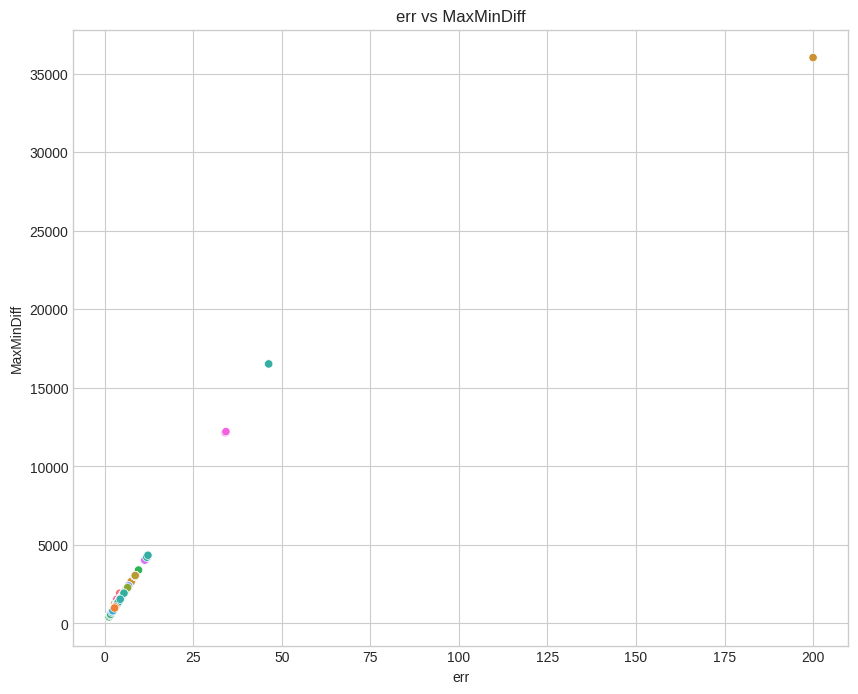

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,8))

plt.title('err vs MaxMinDiff')
sns.scatterplot(x=df['err'],y=df['MaxMinDiff'],hue=df['scanner'],legend= False)
plt.xlabel('err')
plt.ylabel('MaxMinDiff')

plt.show()
plt.tight_layout()

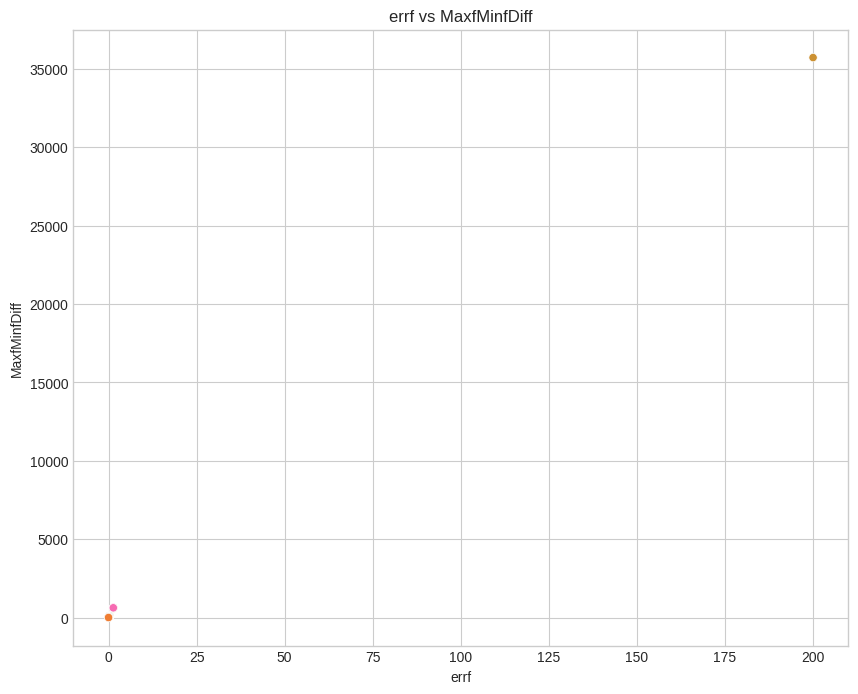

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,8))

plt.title('errf vs MaxfMinfDiff')
sns.scatterplot(x=df['errf'],y=df['MaxfMinfDiff'],hue=df['scanner'],legend= False)
plt.xlabel('errf')
plt.ylabel('MaxfMinfDiff')

plt.show()
plt.tight_layout()

*Err and Errf values are dependent on Max min difference of their respective parameters*
> MaxMinDiff value threshold is approximately 4500 beyond which the Err value goes beyond 12% which is failure of the device

>MaxfMinfDiff value threshold is approximately 150 beyond which the Err value goes beyond 0.5% which is failure of the device

In [ ]:
# Add Failure column which is our output lable

df['Failure'] = np.where((df['err'] >= 12.0) | (df['errf'] >=0.5),2, 1)
df['Failure'].unique()

array([1, 2])

In [ ]:
df['Failure'].value_counts()

Failure
1    2591
2      12
Name: count, dtype: int64

In the dataset, we have only 12 rows which has failure scanner data value available

In [ ]:
df.columns

Index(['id', 'scanner', 'min', 'max', 'err', 'pixels', 'minf', 'maxf', 'errf',
       'duration', 'MaxMinDiff', 'MaxfMinfDiff', 'Failure'],
      dtype='object')

In [ ]:
df_copy = df.drop('scanner',axis =1)

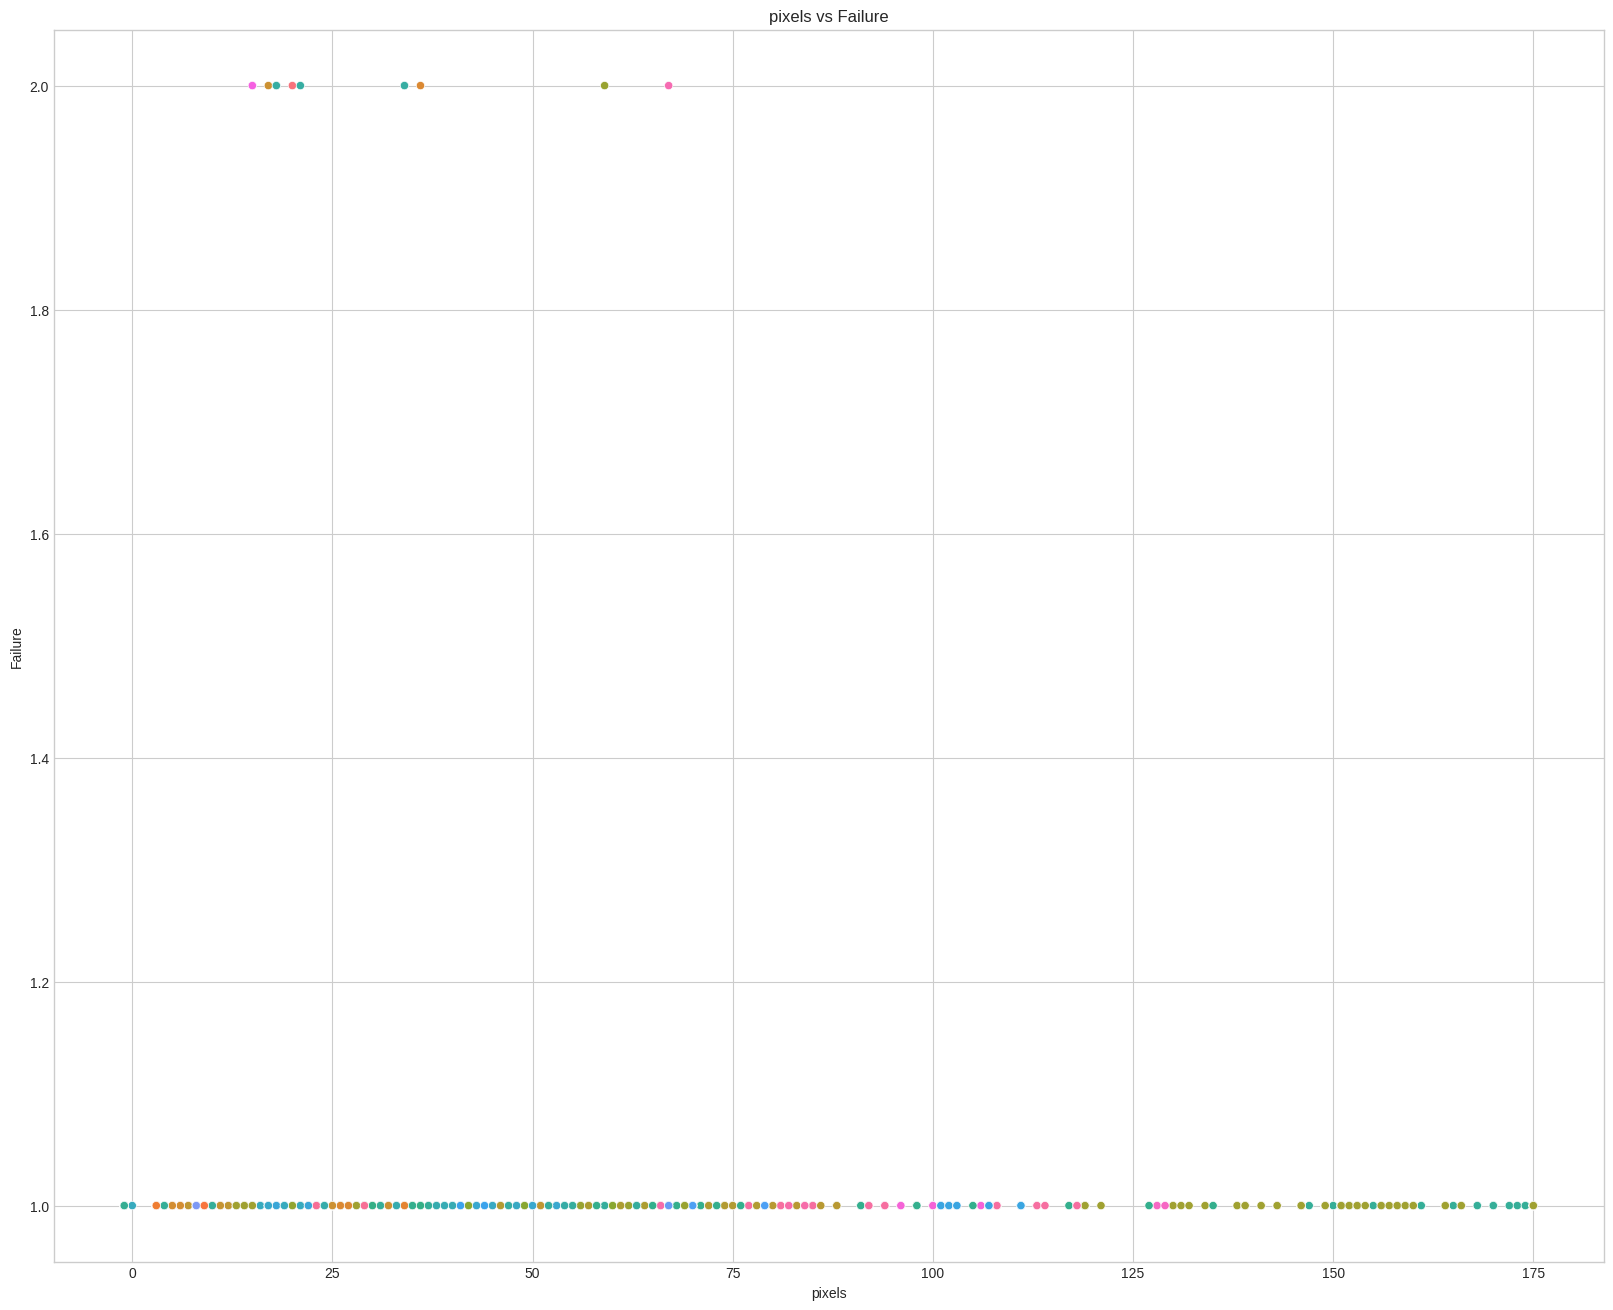

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,16))

plt.title('pixels vs Failure')
sns.scatterplot(x=df_copy['pixels'],y=df_copy['Failure'],hue=df['scanner'], legend = False)
plt.xlabel('pixels')
plt.ylabel('Failure')

plt.show()
plt.tight_layout()

Note : Pixel values are not having influence on the failure


<Axes: xlabel='scanner', ylabel='count'>

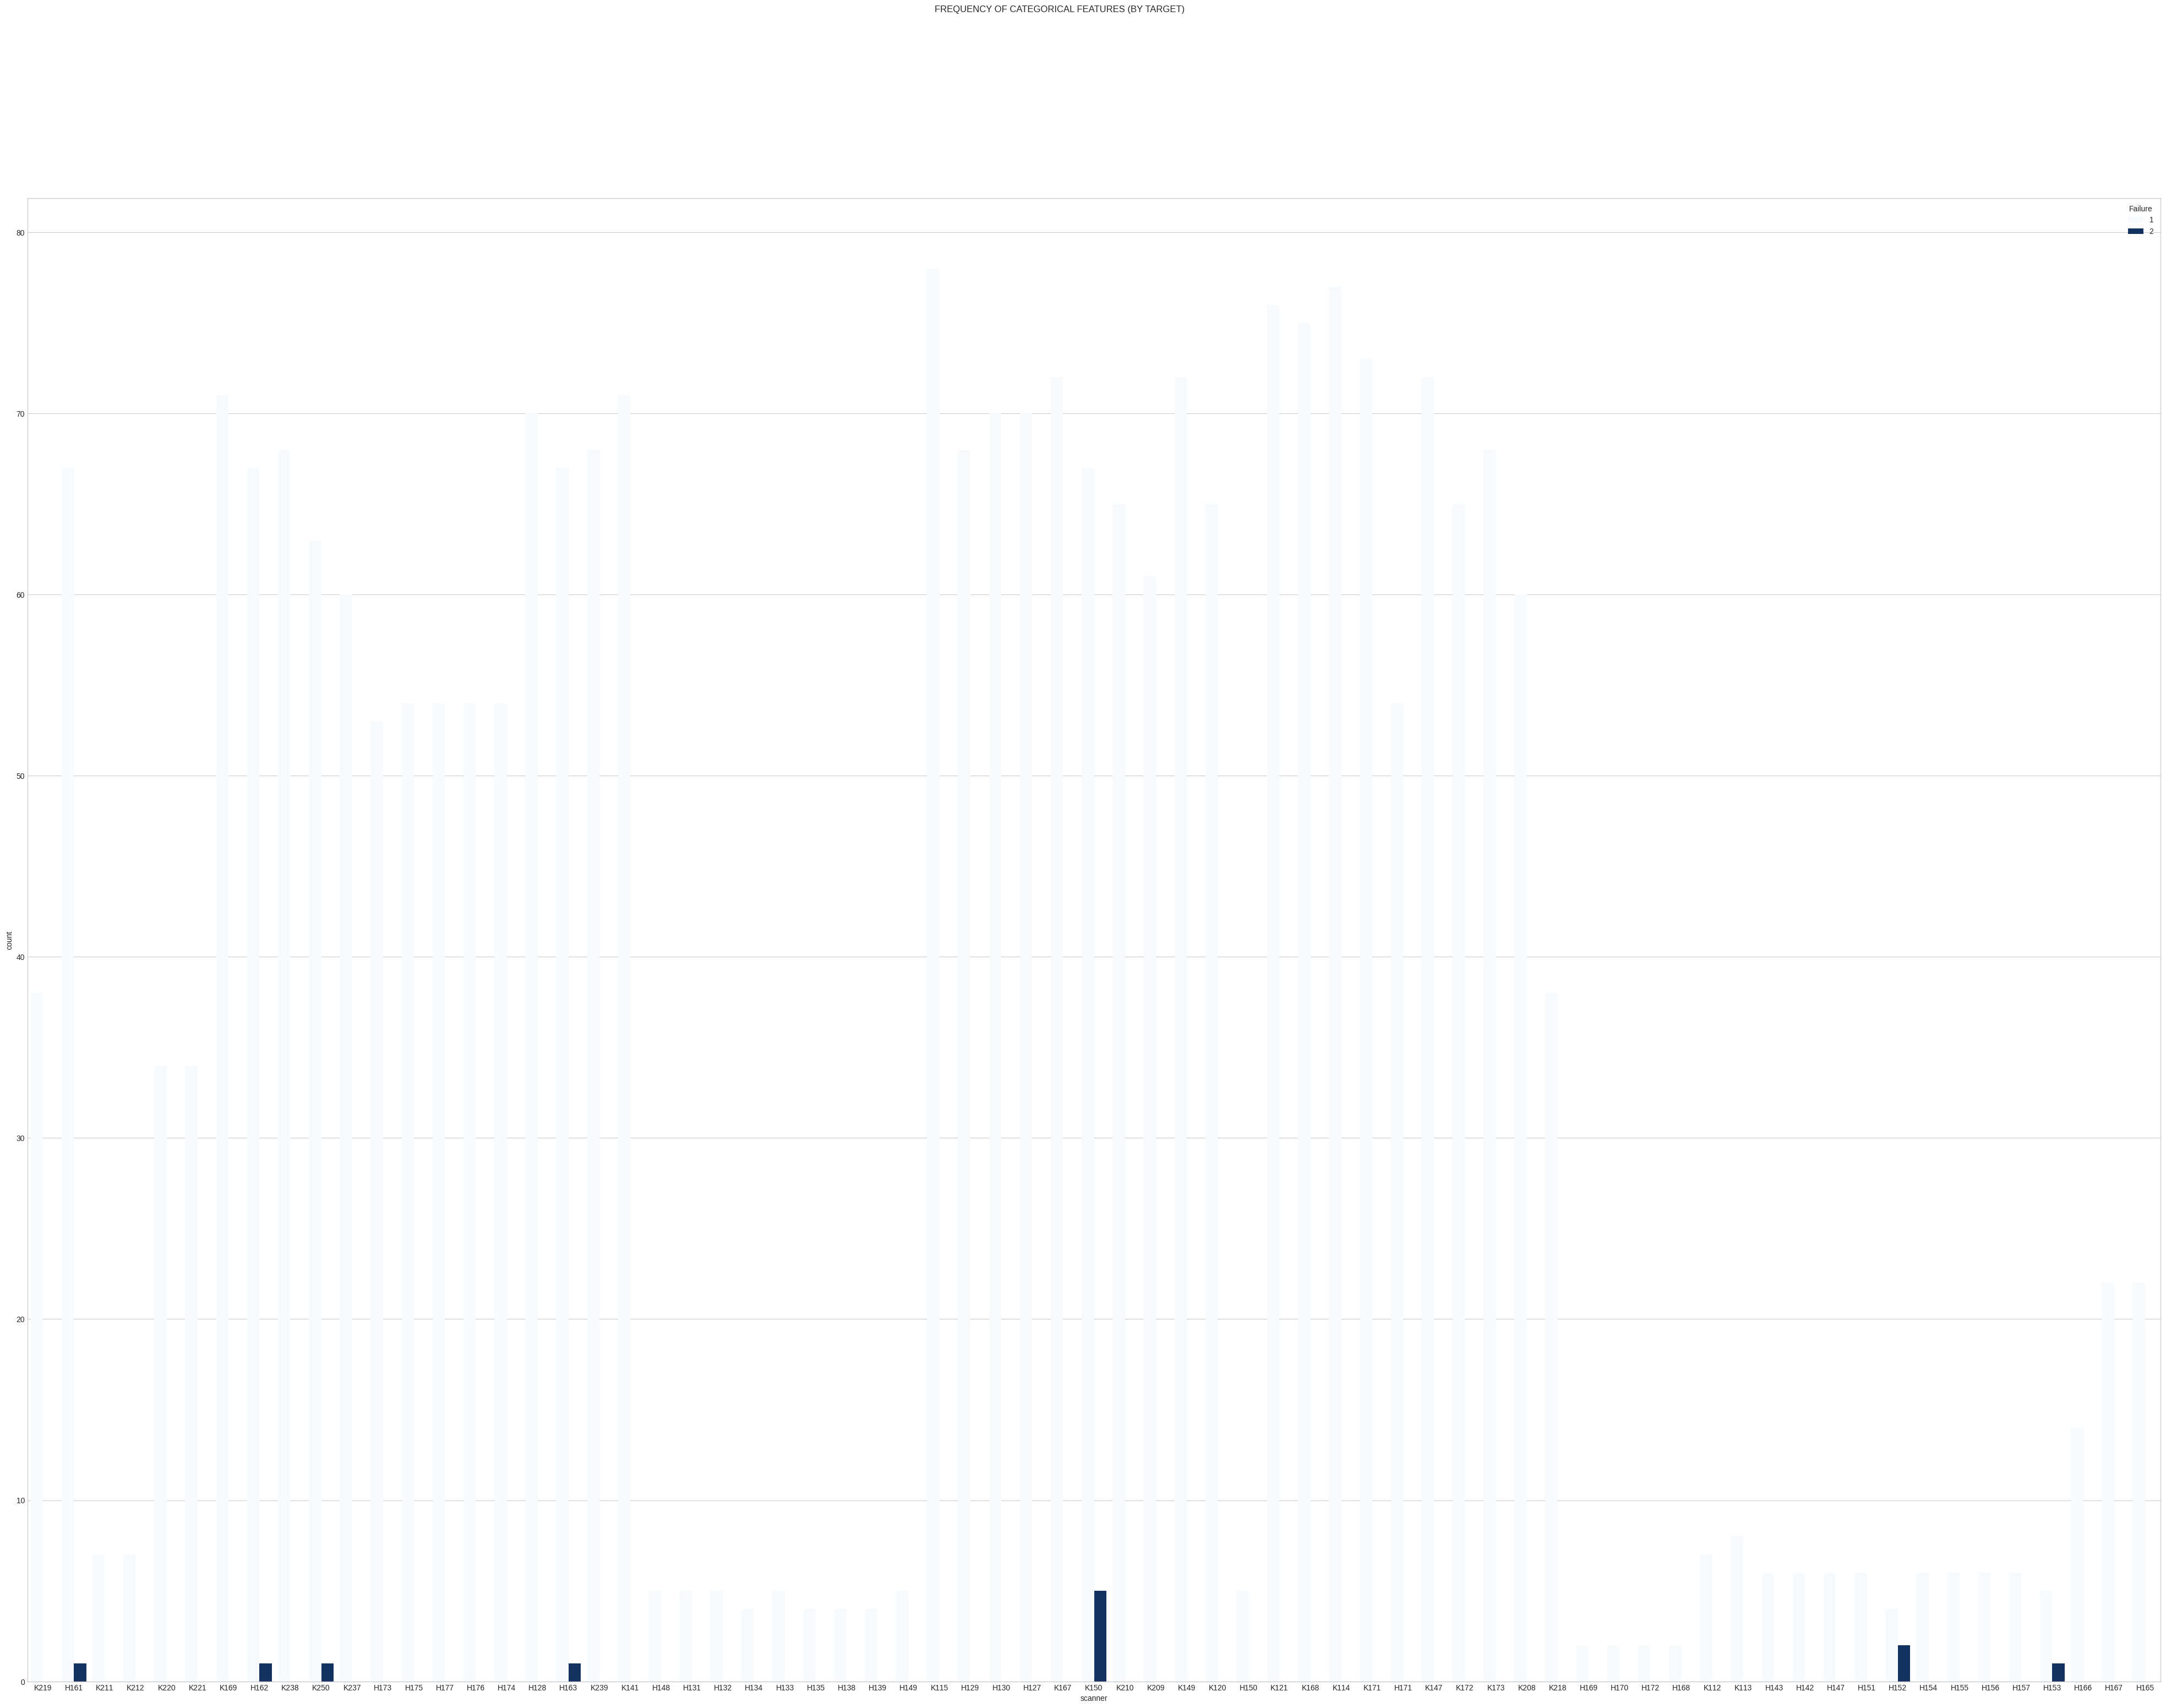

In [ ]:
# Creating a new dataframe with categorical variables


f, axes = plt.subplots(1, 1, figsize=(50, 35), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL FEATURES (BY TARGET)')
sns.countplot(x="scanner", hue="Failure", data=df, palette="Blues")

Note: The dataset is not having all the failure cases of the scanner or only few of the scanner fails


In [ ]:
df_copy1 = pd.concat([df,pd.get_dummies(df['scanner'], prefix='scanner',dummy_na=False)],axis=1).drop(['scanner'],axis=1)

In [ ]:
df_copy1.head()


,id,min,max,err,pixels,minf,maxf,errf,duration,MaxMinDiff,...,scanner_K211,scanner_K212,scanner_K218,scanner_K219,scanner_K220,scanner_K221,scanner_K237,scanner_K238,scanner_K239,scanner_K250
0,12.0,35435.0,35933.0,1.40,6.0,35681.0,35688.0,0.02,12.0,498.0,...,False,False,False,True,False,False,False,False,False,False
1,30.0,35155.0,36382.0,3.43,14.0,35731.0,35761.0,0.08,11.0,1227.0,...,False,False,False,False,False,False,False,False,False,False
2,47.0,35305.0,36042.0,2.07,43.0,35692.0,35739.0,0.13,1.0,737.0,...,True,False,False,False,False,False,False,False,False,False
3,48.0,35216.0,36225.0,2.82,61.0,35686.0,35726.0,0.11,1.0,1009.0,...,False,True,False,False,False,False,False,False,False,False
4,49.0,35196.0,36259.0,2.98,11.0,35709.0,35724.0,0.04,1.0,1063.0,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
df_copy1.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2603 entries, 0 to 2751
Data columns (total 81 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2603 non-null   float64
 1   min           2603 non-null   float64
 2   max           2603 non-null   float64
 3   err           2603 non-null   float64
 4   pixels        2603 non-null   float64
 5   minf          2603 non-null   float64
 6   maxf          2603 non-null   float64
 7   errf          2603 non-null   float64
 8   duration      2603 non-null   float64
 9   MaxMinDiff    2603 non-null   float64
 10  MaxfMinfDiff  2603 non-null   float64
 11  Failure       2603 non-null   int64  
 12  scanner_H127  2603 non-null   bool   
 13  scanner_H128  2603 non-null   bool   
 14  scanner_H129  2603 non-null   bool   
 15  scanner_H130  2603 non-null   bool   
 16  scanner_H131  2603 non-null   bool   
 17  scanner_H132  2603 non-null   bool   
 18  scanner_H133  2603 non-null   boo

In [ ]:
df_copy1['max'].describe()

count     2603.000000
mean     36200.400307
std        554.719813
min      35761.000000
25%      36007.500000
50%      36119.000000
75%      36264.000000
max      47057.000000
Name: max, dtype: float64

<ipython-input-136-3bd91b5eec6e>:3: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

<ipython-input-136-3bd91b5eec6e>:4: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

<ipython-input-136-3bd91b5eec6e>:5: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



<Axes: xlabel='Failure', ylabel='duration'>

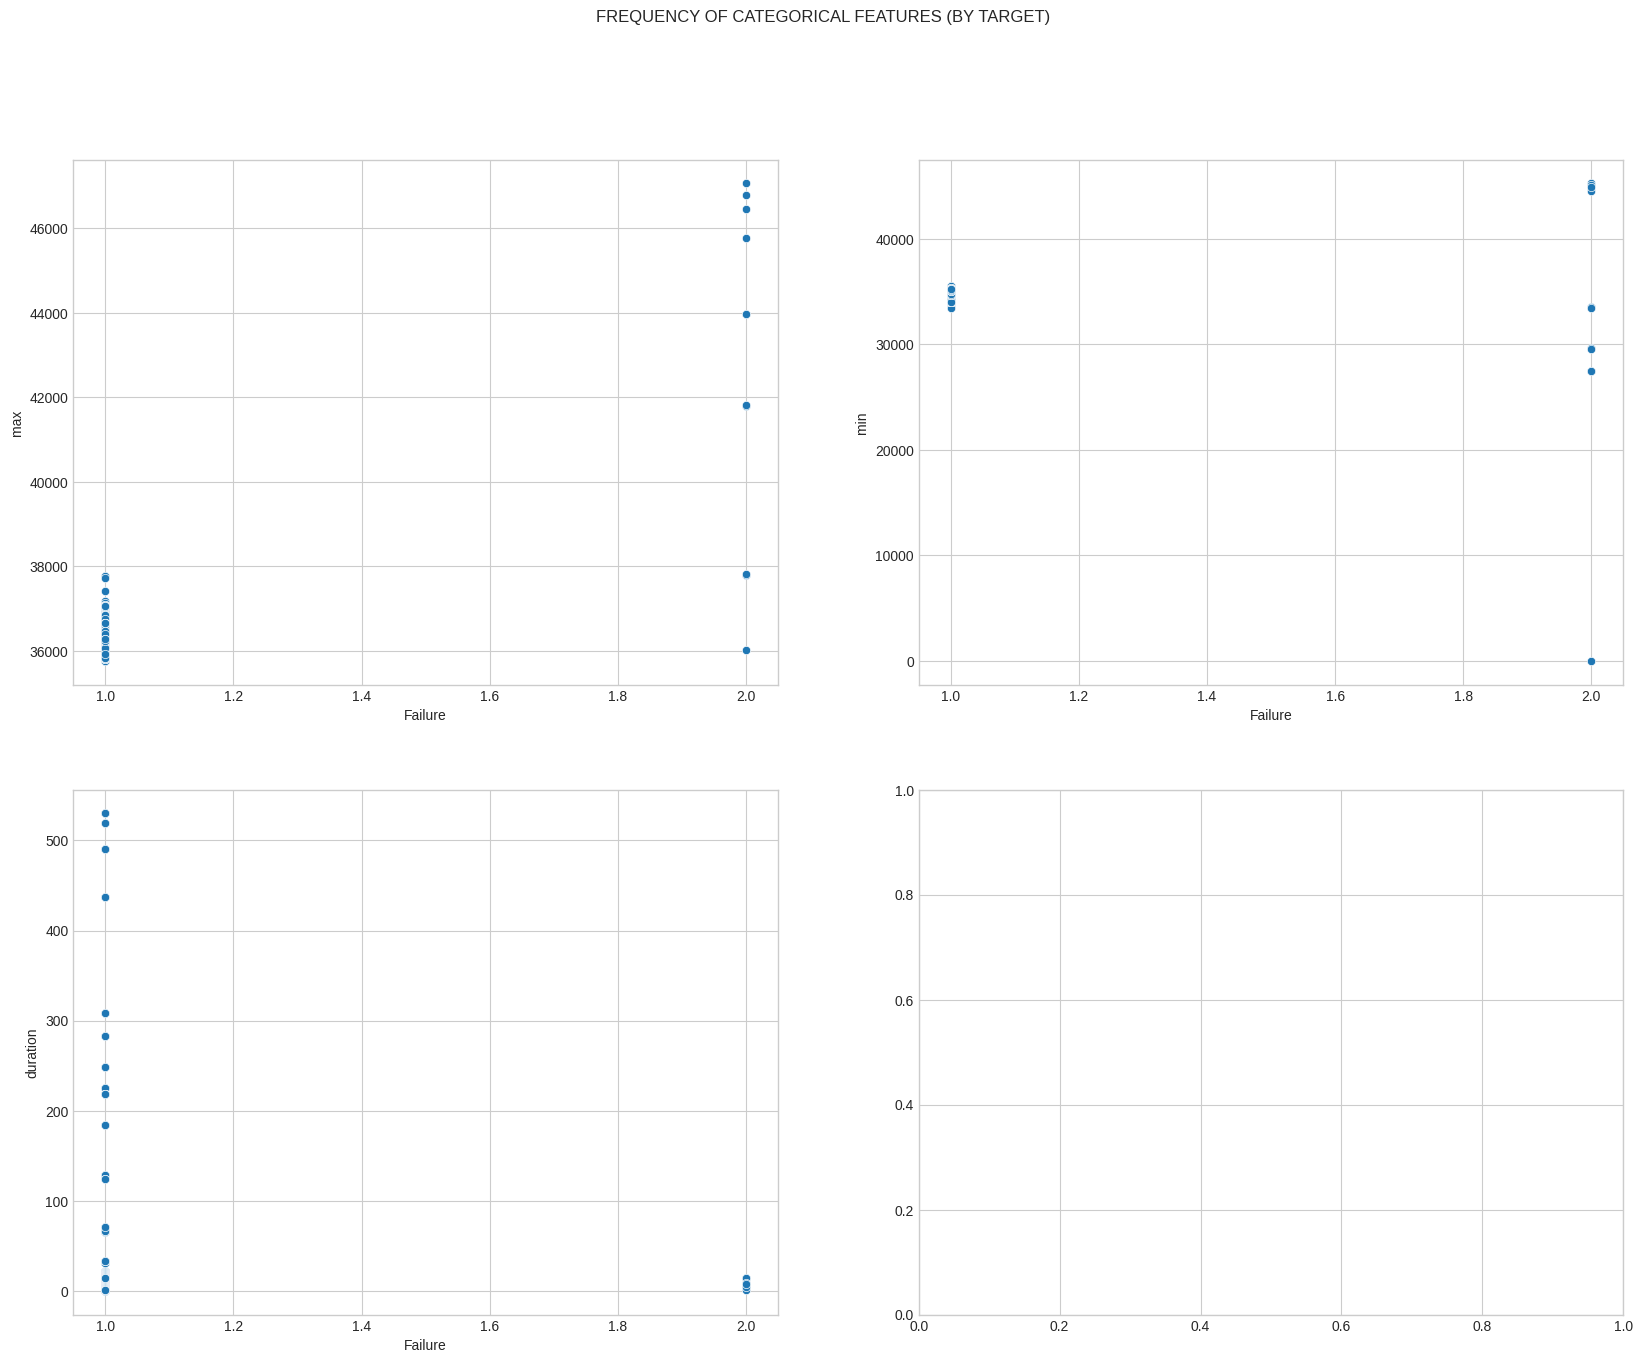

In [ ]:
f, axes = plt.subplots(2,2, figsize=(20, 15), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL FEATURES (BY TARGET)')
sns.scatterplot(x=df_copy1['Failure'],y=df_copy1['max'],palette ="Set1",ax=axes[0,0])
sns.scatterplot(x=df_copy1['Failure'],y=df_copy1['min'],palette ="Set1", ax=axes[0,1])
sns.scatterplot(x=df_copy1['Failure'],y=df_copy1['duration'],palette ="Set1", ax=axes[1,0])

In [ ]:
df_copy1.columns.size


81

In [ ]:
df_copy1['scanner_H150'].value_counts()


scanner_H150
False    2598
True        5
Name: count, dtype: int64

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df_copy1, x='MaxMinDiff', y='err', z='pixels',
              color='scanner_K150')
fig.show()

Final thought before modeling

> The difference between Max and Min increases then the scanner will likly towards failure after the value becomes 4000 and above

>The difference between Maxf and Minf increases then the scanner will likly towards failure after the value becomes 100/90 and above

Failure category:

    Never fail : Failure = 1

    Routinely fail: Failure = 2

    Expected to fail/Failing faster: Failure = 3

In [ ]:
df_model = df_copy1.copy()


In [ ]:
df_copy1['Failure'] = np.where(((df_copy1['MaxMinDiff'] >= 4000) & (df_copy1['MaxMinDiff'] <= 4280)) |((df_copy1['MaxfMinfDiff'] >= 90) & (df_copy1['MaxfMinfDiff'] <= 120)),3, df_copy1['Failure'])


In [ ]:
df_copy1['Failure'].value_counts()


Failure
1    2565
3      27
2      11
Name: count, dtype: int64

Data Split


In [ ]:
# Original dataset
X = df_copy1.drop('Failure', axis=1)
Y = df_copy1['Failure']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, stratify=Y, random_state=45)

In [ ]:
rf = RandomForestClassifier()

def model_classifier(mod_est):
      brk_str = '=='*50
      parameters = {'n_estimators': [50, 150, 250],'max_depth': [4, 8, 16, 32, 64, None]}
      print(brk_str)
      cv = GridSearchCV(rf, parameters, cv=10)
      cv.fit(X_train, Y_train)
      print(brk_str)
      print(cv.best_params_)
      print(brk_str)
      Y_pred= cv.predict(X_test)
      print('Accuracy:', metrics.accuracy_score(Y_pred,Y_test))

      cv_scores =cross_val_score(cv, X, Y, cv=5)
      print(brk_str)
      print(' Print the 5-fold cross-validation scores')
      print(brk_str)
      print(classification_report(Y_test, Y_pred))
      print()
      print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),", Standard deviation: {}".format(round(np.std(cv_scores),4)))
      ConfMatrix = confusion_matrix(Y_test,cv.predict(X_test))
      print()
      print(ConfMatrix)
      print()
      print(brk_str)

      print('Sample Test check')
      sample_test = df_copy1.loc[(df_copy1['scanner_K150'] == 1) & (df_copy1['Failure'] == 3)]
      Ypred_sample = cv.predict(sample_test.drop(['Failure'],axis = 1))
      print(Ypred_sample)
      print(brk_str)

In [ ]:
model_classifier(RandomForestClassifier())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



{'max_depth': None, 'n_estimators': 50}
Accuracy: 0.9974391805377721


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 9 members, which is less than n_splits=10.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 9 members, which is less than n_splits=10.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 9 members, which is less than n_splits=10.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 9 members, which is less than n_splits=10.



 Print the 5-fold cross-validation scores
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       770
           2       1.00      1.00      1.00         3
           3       0.80      1.00      0.89         8

    accuracy                           1.00       781
   macro avg       0.93      1.00      0.96       781
weighted avg       1.00      1.00      1.00       781


Average 5-Fold CV Score: 0.9969 , Standard deviation: 0.0026

[[768   0   2]
 [  0   3   0]
 [  0   0   8]]

Sample Test check
[3 3 3]


Gradient Boosting Classifier


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model_classifier(GradientBoostingClassifier())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.



{'max_depth': 16, 'n_estimators': 50}
Accuracy: 0.9974391805377721


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 8 members, which is less than n_splits=10.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 9 members, which is less than n_splits=10.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 9 members, which is less than n_splits=10.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 9 members, which is less than n_splits=10.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 9 members, which is less than n_splits=10.



 Print the 5-fold cross-validation scores
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       770
           2       1.00      1.00      1.00         3
           3       0.80      1.00      0.89         8

    accuracy                           1.00       781
   macro avg       0.93      1.00      0.96       781
weighted avg       1.00      1.00      1.00       781


Average 5-Fold CV Score: 0.9969 , Standard deviation: 0.0023

[[768   0   2]
 [  0   3   0]
 [  0   0   8]]

Sample Test check
[3 3 3]


Conclusion:

>Based on the model estimation both the model's the accuracy and precision and recall values are satisfactory along with cross-validation scores
Gradient Boosting model gives results faster than Random Forest.